## Classification course project

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

## Data loading

In [5]:
DATASET_PATH = "../../data/classification/train.csv"
df_train = pd.read_csv(DATASET_PATH)
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [6]:
TEST_DATASET_PATH = "../../data/classification/test.csv"
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


### Features

- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
- Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## EDA

In [7]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130934,18.317467,9.451538e+05,0.170000,34.692600,0.117152,11873178.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688807,0.347192,31926124.0,3.178714e+05,11926.764648,1604.451416,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.000000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
df_train.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

In [9]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [10]:
df_train.shape

(7500, 17)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [12]:
df_train["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Categories

In [13]:
for cat_colname in df_train.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + "Mode: " + str(df_train[cat_colname].mode()) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Mode: 0    Home Mortgage
Name: Home Ownership, dtype: category
Categories (4, object): ['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

Mode: 0    10+ years
Name: Years in current job, dtype: category
Categories (11, object): ['1 year', '10+ years', '2 years', '3 years', ..., '7 years', '8 years', '9 years', '< 1 year']

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

Mode: 0    debt consolidation
Name: Purpose, dtype: categ

## Data Preprocessing

In [14]:
class ClassificationDataPreprocessor:
    
    def __init__(self):
        self.target_name = 'Credit Default'
        self.cat_features = ['Home Ownership', 'Years in current job','Purpose','Term']
        self.float_features = ['Annual Income','Tax Liens','Number of Open Accounts', 'Years of Credit History','Maximum Open Credit','Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        self.medians = []
        self.modes = []
    
    def fit(self, inner_df):
        # Расчет медиан
        self.medians = inner_df[self.float_features].median()
        # Расчет мод
        self.modes = inner_df[self.cat_features].mode().squeeze()
    
    
    def transform(self, inner_df, is_test=False):
        
        # Замена пропусков
        inner_df[self.float_features] = inner_df[self.float_features].fillna(self.medians[self.float_features])
        inner_df[self.cat_features] = inner_df[self.cat_features].fillna(self.modes[self.cat_features])
        
        
        return inner_df
        
                
    def replace_with_median(self, df:pd.DataFrame, condition:pd.Series, feature:str):
        df.loc[condition, feature] = self.medians[feature]


In [15]:
data_preprocessor = ClassificationDataPreprocessor()
data_preprocessor.fit(df_train)
df_train = data_preprocessor.transform(df_train)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 7500 non-null   float32 
 2   Years in current job          7500 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [17]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.299999,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,32.0,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.500000,1141250.0,0.0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0


## Balancing

In [18]:
class ClassificationBalancer:
    
    def __init__(self):
        self.target_name = 'Credit Default'
        self.disbalance_coeff = None
        self.major_class_name = None
        self.minor_class_name = None
        self.target_counts = None
        
    
    def fit(self, inner_df):
        # Расчет коэффициента отклонения
        self.target_counts = inner_df[self.target_name].value_counts()

        self.major_class_name = self.target_counts.argmax()
        self.minor_class_name = self.target_counts.argmin()
        
        self.disbalance_coeff = int(self.target_counts[self.major_class_name] / self.target_counts[self.minor_class_name]) - 1
    
    
    def transform(self, inner_df, is_test=False):
        # Балансировка
        for i in range(self.disbalance_coeff):
            sample = inner_df[inner_df[self.target_name] == self.minor_class_name].sample(self.target_counts[self.minor_class_name])
            inner_df = inner_df.append(sample, ignore_index=True)

        return inner_df.sample(frac=1)

In [19]:
balancer = ClassificationBalancer()
balancer.fit(df_train)
df_train = balancer.transform(df_train)

In [20]:
df_train['Credit Default'].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

### Test data preprocessing

In [21]:
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,100000000.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.800000,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.799999,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

In [23]:
df_test_transformed = data_preprocessor.transform(df_test)

## Feature processing

### Categories

Категории заменяем на даммис, где мало признаков = Home Ownership и Term

Years in current job за меняем на 4 периода

Purpose попробуем разложить через таргет

- debt consolidation      5944 0
- other                    665 1
- home improvements        412 3
- business loan            129 2
- buy a car                 96 3
- medical bills             71 1
- major purchase            40 2
- take a trip               37 3
- buy house                 34 3
- small business            26 2
- wedding                   15 3
- moving                    11 3
- educational expenses      10 3
- vacation                   8 3
- renewable energy           2 2

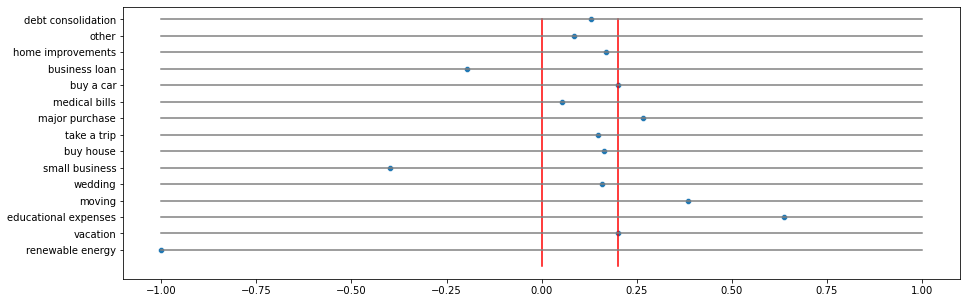

In [24]:
df_train[['Purpose']].value_counts().keys()
purp_cats = df_train[['Purpose']].value_counts().keys()
coords = {}
for c in purp_cats:
    returned_dict = dict(df_train.loc[df_train['Purpose'] == c[0], 'Credit Default'].value_counts())
    if 0 not in returned_dict.keys():
        returned_dict[0] = 0
    if 1 not in returned_dict.keys():
        returned_dict[1] = 0
    return_diff = (returned_dict[0] - returned_dict[1]) / (returned_dict[0] + returned_dict[1])
    coords[c[0]]=return_diff

figure = plt.figure(figsize = (15, 5))

plt.plot([0,0],[0,15],color='red')
plt.plot([0.2,0.2],[0,15],color='red')
for i in range(0, 15):
    plt.plot([-1,1],[i,i], color='gray')
sns.scatterplot(y=list(coords.keys()), x=list(coords.values()))
plt.show()

In [25]:
bad_purpose = []
average_purpose = []
good_purpose = []
for p in coords:
    elem = coords[p]
    if elem < 0:
        bad_purpose.append(p)
    elif elem >= 0 and elem < 0.2:
        average_purpose.append(p)
    elif elem >= 0.2:
        good_purpose.append(p)
#inner_df['bad_purpose'] = 0
#inner_df['average_purpose'] = 0
#inner_df['good_purpose'] = 0
for b in bad_purpose:
    df_train.loc[df_train['Purpose'] == b, 'Purpose']
for a in average_purpose:
    df_train.loc[df_train['Purpose'] == a, 'Purpose']
for g in good_purpose:
    df_train.loc[df_train['Purpose'] == g, 'Purpose']


In [26]:
class ClassificationFeatureProcessor:
    
    
    def __init__(self, target_name):
        self.target_name = target_name
        self.bad_purpose = None
        self.average_purpose = None
        self.good_purpose = None
        
    
    def fit(self, inner_df):
        #Поиск видов Purpose
        self.purpose_to_binary_fit(inner_df)
        
    
    def transform(self, inner_df, is_test=False):
        #Замена Homeownership на даммис
        inner_df = self.replace_with_dummies(inner_df, 'Home Ownership', 'H_O')
        #Замена Term на даммис
        inner_df = self.replace_with_dummies(inner_df, 'Term', 'Term')
        #Замена Years in current job на бинарные признаки для работы моделей не работающих с категориями
        inner_df = self.year_to_dummies(inner_df)
        #Замена Purpose на бинарные признаки
        inner_df = self.purpose_to_binary_transform(inner_df)
        return inner_df
        
    def replace_with_dummies(self, df, feature, prefix):
        df = pd.concat([df, pd.get_dummies(df[feature], prefix)], axis=1)
        df = df.drop(columns=feature)
        return df
    
    def year_to_dummies(self, inner_df):
        years_cat_name = 'Years in current job'
        dummy_df = inner_df.copy()
        dummy_df[[years_cat_name]].value_counts().keys()
        cats = dummy_df[[years_cat_name]].value_counts().keys()
        new_nums = []
        for i in cats:
            c = i[0].split()
            result = ''
            filtered_num = result.join(list(filter(lambda x: x.isnumeric(), [char for char in c[0]])))
            if filtered_num.isnumeric():
                new_nums.append({int(filtered_num): i[0]})
            else:
                new_nums.append({int(0): i[0]})
        dummy_df['Experience_0'] = 0
        dummy_df['Experience_1_5'] = 0
        dummy_df['Experience_5_10'] = 0
        dummy_df['Experience_10+'] = 0
        for j in new_nums:
            num_cat_name = list(j.keys())[0]
            string_cat_name = list(j.values())[0]
            if num_cat_name < 1:
                dummy_df.loc[dummy_df[years_cat_name] == string_cat_name, 'Experience_0'] = 1
            elif num_cat_name in range(1, 5):
                dummy_df.loc[dummy_df[years_cat_name] == string_cat_name, 'Experience_1_5'] = 1
            elif num_cat_name in range(5, 10):
                dummy_df.loc[dummy_df[years_cat_name] == string_cat_name, 'Experience_5_10'] = 1
            elif num_cat_name >= 10:
                dummy_df.loc[dummy_df[years_cat_name] == string_cat_name, 'Experience_10+'] = 1
        dummy_df = dummy_df.drop(years_cat_name, axis=1)
        return dummy_df
        
    def purpose_to_binary_fit(self, inner_df):
        dummy_df = inner_df.copy()
        purpose_cat_name = 'Purpose'
        dummy_df[[purpose_cat_name]].value_counts().keys()
        purp_cats = dummy_df[[purpose_cat_name]].value_counts().keys()
        coords = {}
        for c in purp_cats:
            returned_dict = dict(dummy_df.loc[dummy_df[purpose_cat_name] == c[0], self.target_name].value_counts())
            if 0 not in returned_dict.keys():
                returned_dict[0] = 0
            if 1 not in returned_dict.keys():
                returned_dict[1] = 0
            return_diff = (returned_dict[0] - returned_dict[1]) / (returned_dict[0] + returned_dict[1])
            coords[c[0]]=return_diff
        bad_purpose = []
        average_purpose = []
        good_purpose = []
        for p in coords:
            elem = coords[p]
            if elem < 0:
                bad_purpose.append(p)
            elif elem >= 0 and elem < 0.2:
                average_purpose.append(p)
            elif elem >= 0.2:
                good_purpose.append(p)
        self.bad_purpose = bad_purpose
        self.average_purpose = average_purpose
        self.good_purpose = good_purpose
        
        
    def purpose_to_binary_transform(self, inner_df):
        dummy_df = inner_df.copy()
        purpose_cat_name = 'Purpose'
        dummy_df['bad_purpose'] = 0
        dummy_df['average_purpose'] = 0
        dummy_df['good_purpose'] = 0
        for b in self.bad_purpose:
            dummy_df.loc[dummy_df[purpose_cat_name] == b, 'bad_purpose'] = 1
        for a in self.average_purpose:
            dummy_df.loc[dummy_df[purpose_cat_name] == a, 'average_purpose'] = 1
        for g in self.good_purpose:
            dummy_df.loc[dummy_df[purpose_cat_name] == g, 'good_purpose'] = 1
        dummy_df = dummy_df.drop(purpose_cat_name, axis=1)
        return dummy_df

In [27]:
feature_processor = ClassificationFeatureProcessor('Credit Default')
feature_processor.fit(df_train)
df_train = feature_processor.transform(df_train)

In [28]:

df_train

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,H_O_Rent,Term_Long Term,Term_Short Term,Experience_0,Experience_1_5,Experience_5_10,Experience_10+,bad_purpose,average_purpose,good_purpose
9542,1168386.0,0.0,11.0,16.000000,459976.0,1.0,32.0,1.0,261602.0,305881.0,...,0,0,1,0,1,0,0,0,1,0
2943,845253.0,0.0,7.0,15.300000,333366.0,0.0,32.0,0.0,217492.0,269477.0,...,0,0,1,0,0,0,1,0,1,0
451,687344.0,0.0,10.0,35.599998,506264.0,0.0,23.0,0.0,100000000.0,310441.0,...,0,1,0,0,0,0,1,0,1,0
5784,1168386.0,0.0,4.0,8.700000,363990.0,0.0,32.0,0.0,42900.0,246126.0,...,1,0,1,0,1,0,0,0,1,0
7285,1028242.0,0.0,6.0,13.900000,123596.0,0.0,43.0,0.0,100000000.0,56791.0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,3341625.0,1.0,18.0,28.700001,1694088.0,2.0,76.0,1.0,773850.0,509143.0,...,0,1,0,0,1,0,0,0,1,0
3607,2181105.0,0.0,12.0,12.800000,870628.0,0.0,32.0,0.0,633050.0,717326.0,...,1,0,1,0,1,0,0,0,1,0
2792,1145814.0,0.0,10.0,25.799999,143748.0,0.0,35.0,0.0,331694.0,107521.0,...,0,0,1,0,0,1,0,0,1,0
6826,1149101.0,0.0,10.0,10.100000,557304.0,0.0,32.0,0.0,228954.0,175199.0,...,0,0,1,0,0,0,1,0,1,0


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9613 entries, 9542 to 2383
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 9613 non-null   float32
 1   Tax Liens                     9613 non-null   float32
 2   Number of Open Accounts       9613 non-null   float32
 3   Years of Credit History       9613 non-null   float32
 4   Maximum Open Credit           9613 non-null   float32
 5   Number of Credit Problems     9613 non-null   float32
 6   Months since last delinquent  9613 non-null   float32
 7   Bankruptcies                  9613 non-null   float32
 8   Current Loan Amount           9613 non-null   float32
 9   Current Credit Balance        9613 non-null   float32
 10  Monthly Debt                  9613 non-null   float32
 11  Credit Score                  9613 non-null   float32
 12  Credit Default                9613 non-null   int8   
 13  

### Test feature processing

In [30]:
df_test_transformed = feature_processor.transform(df_test_transformed, is_test=True)

## Training

In [31]:
class ClassificationModelLearningProcessor:
    
    def __init__(self, target_name):
        self.target_name = target_name
        self.trn_dataset = None
        self.test_dataset = None
        #Original = Before transformations
        self.original_test_dataset = None
        #Для заключительного обучения
        self.trn_X_full = None
        self.trn_y_full = None
        #Для промежуточного обучения и анализа
        self.trn_X_split_train = None
        self.trn_y_split_train = None
        self.trn_X_split_test = None
        self.trn_y_split_test = None
        
        self.split_y_train_preds = None
        self.full_y_train_preds = None
        self.test_preds = None
        
        self.cross_val_full_result = None
        self.cross_val_split_result = None
        
    def fit(self, trn_dataset, test_dataset, original_test_dataset):
        #заполнение и разделение датасетов
        self.trn_dataset = trn_dataset
        self.test_dataset = test_dataset
        self.original_test_dataset = original_test_dataset
        
        feature_names = self.get_feature_names(trn_dataset, self.target_name)
        self.trn_X_full = trn_dataset[feature_names]
        self.trn_y_full = trn_dataset[self.target_name]

        self.trn_X_split_train, self.trn_X_split_test, self.trn_y_split_train, self.trn_y_split_test = \
        train_test_split(self.trn_X_full, self.trn_y_full, test_size=0.33, shuffle=True, random_state=42)
    
    def fit_predict_split(self, inner_model):
        self.fit_split(inner_model)
        self.predict_split(inner_model)
        
    def fit_split(self, inner_model):
        inner_model.fit(self.trn_X_split_train, self.trn_y_split_train)
        
    def predict_split(self, inner_model):
        inner_model.predict(self.trn_X_split_train)
        self.split_y_train_preds = inner_model.predict(self.trn_X_split_train)
        self.split_y_test_preds = inner_model.predict(self.trn_X_split_test)
        
    def evaluate_split(self, inner_model, with_cross_val=False):
        #Train train part
        print(classification_report(np.squeeze(self.trn_y_split_train.values), self.split_y_train_preds))
        y_split_pred_probs = inner_model.predict_proba(self.trn_X_split_train)
        show_proba_calibration_plots(y_split_pred_probs[:, 1], self.trn_y_split_train.values)
        #Train Test part
        print(classification_report(np.squeeze(self.trn_y_split_test.values), self.split_y_test_preds))
        y_split_test_pred_probs = inner_model.predict_proba(self.trn_X_split_test)
        show_proba_calibration_plots(y_split_test_pred_probs[:, 1], self.trn_y_split_test.values)

        
    def fit_predict_full(self, inner_model):
        self.fit_full(inner_model)
        self.predict_full(inner_model)
        
    def fit_full(self, inner_model):
        inner_model.fit(self.trn_X_full, self.trn_y_full)
        
    def predict_full(self, inner_model):
        inner_model.predict(self.trn_X_full)
        self.full_y_train_preds = inner_model.predict(self.trn_X_full)
        
    def evaluate_full(self, inner_model, with_cross_val=False):
        print(classification_report(np.squeeze(self.trn_y_full.values), self.full_y_train_preds))
        y_full_pred_probs = inner_model.predict_proba(self.trn_X_full)
        show_proba_calibration_plots(y_full_pred_probs[:, 1], self.trn_y_full.values)
        
    def predict_test(self, inner_model):
        self.test_preds = inner_model.predict(self.test_dataset)
        
    def save_test(self, prefix):
        result_df = pd.DataFrame(self.test_preds, columns=[self.target_name])
        dataset_with_id = self.original_test_dataset.reset_index().rename({'index':'Id'}, axis = 'columns')
        result_df = pd.concat([dataset_with_id['Id'], result_df], axis=1)
        date = datetime.datetime.now()
        timestamp = f"{date.year}-{date.month}-{date.day}-{date.hour}-{date.minute}-{date.second}"
        result_df.to_csv(f"{prefix}_predictions-{timestamp}.csv", index=False)

    def cross_val_split(self, inner_model):
        cv_score = cross_val_score(inner_model, self.trn_X_split_train, self.trn_y_split_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21), n_jobs=-1)
        return cv_score
        
    def cross_val_full(self, inner_model):
        cv_score = cross_val_score(inner_model, self.trn_X_full, self.trn_y_full, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
        return cv_score
    
    def get_feature_names(self, dataset, target):
        return list(filter(lambda x: x != target, dataset.columns.tolist()))
        

In [32]:
class ClassificationModelFactory:
    
    def __init__(self):
        self.models = None
    
    def get_stack_model(self, models=None):
        if models == None:
            if self.models == None:
                inner_xgb_model = self.get_xgb_model()
                inner_lgb_model = self.get_lgb_model()
                inner_lr_model = self.get_lr_model()
                inner_kn_model = self.get_kn_model()
                
                self.models = [
                    ('xgb', inner_xgb_model), 
                    ('lbg', inner_lgb_model),
                    ('lr', inner_lr_model),
                    ('kn', inner_kn_model)
                ]
        else:
            self.models = models
            
        return StackingClassifier(self.models)
    
    def get_lr_model(self):
        lr_model = LogisticRegression(random_state=21, class_weight='balanced', n_jobs=8)
        return lr_model
    
    def get_kn_model(self):
        kn_model = KNeighborsClassifier(n_jobs=8)
        return kn_model

    def get_xgb_model(self):
        inner_xgb_model = XGBClassifier(random_state=21,
                      tree_method='hist',
                      subsample=1.0,
                      n_estimators=500,
                      learning_rate=0.01,
                      max_depth=6,
                      importance_type='total_cover',
                      colsample_bytree=1.0,
                      booster='dart',
                      n_jobs=8)
        
        return inner_xgb_model
    
    
    def get_lgb_model(self):
        inner_lgb_model = LGBMClassifier(random_state=21, 
             num_leaves=10,
             n_estimators=500,
             max_depth=5,
             max_bin=300,
             learning_rate= 0.03,
            n_jobs=8)
    
        return inner_lgb_model 

In [33]:
model_factory = ClassificationModelFactory()
stack_model = model_factory.get_stack_model()

In [34]:
learning_processor = ClassificationModelLearningProcessor('Credit Default')
learning_processor.fit(df_train, df_test_transformed, df_test)

In [35]:
learning_processor.fit_predict_split(stack_model)

[19:34:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:35:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3631
           1       0.83      0.72      0.77      2809

    accuracy                           0.81      6440
   macro avg       0.82      0.80      0.81      6440
weighted avg       0.82      0.81      0.81      6440



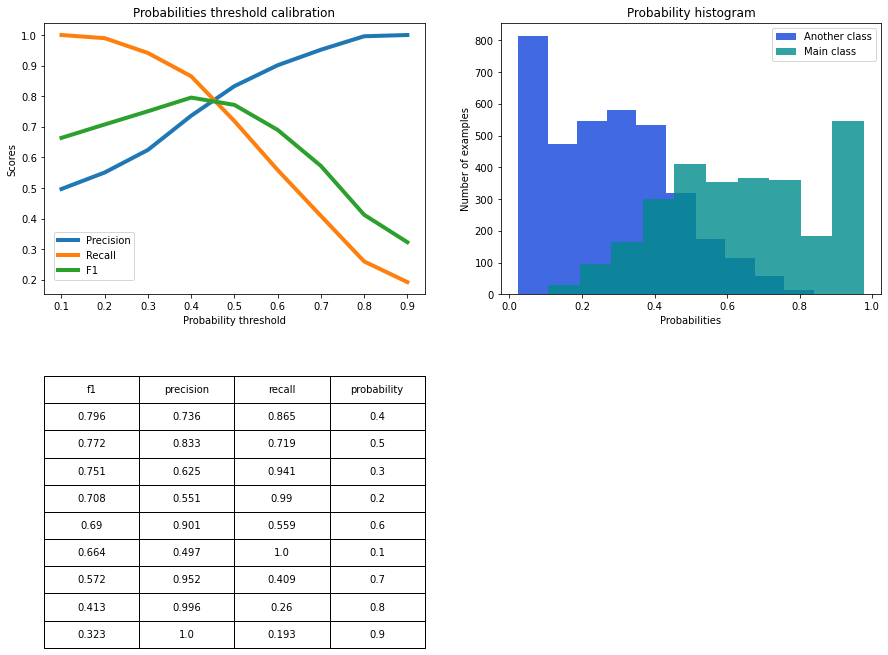

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1756
           1       0.73      0.62      0.67      1417

    accuracy                           0.73      3173
   macro avg       0.73      0.72      0.72      3173
weighted avg       0.73      0.73      0.73      3173



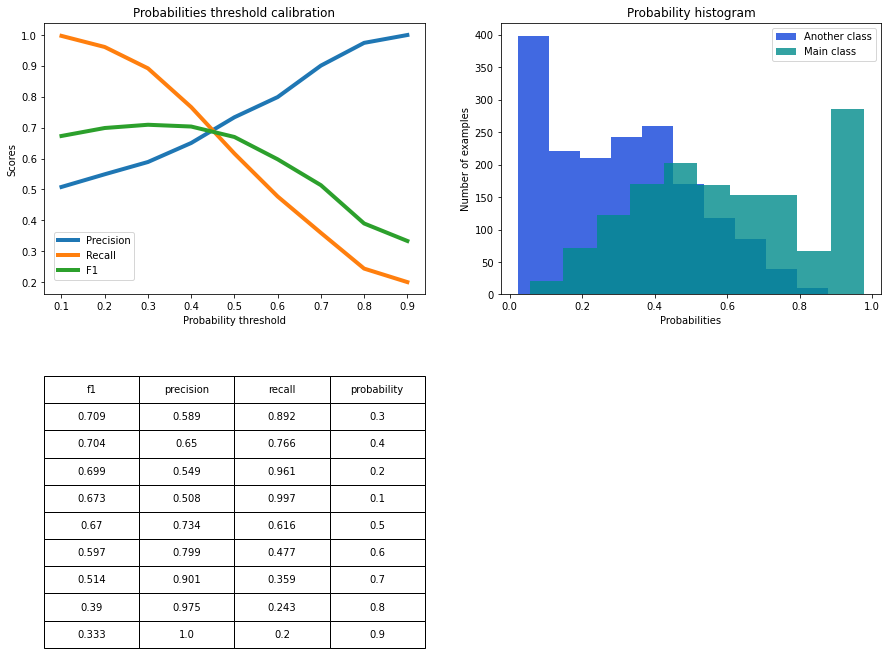

In [36]:
learning_processor.evaluate_split(stack_model)

In [37]:
learning_processor.fit_predict_full(stack_model)

/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/romanmakuta/miniforge3/envs/data-science/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       0.82      0.89      0.85      5387
           1       0.84      0.75      0.79      4226

    accuracy                           0.82      9613
   macro avg       0.83      0.82      0.82      9613
weighted avg       0.83      0.82      0.82      9613



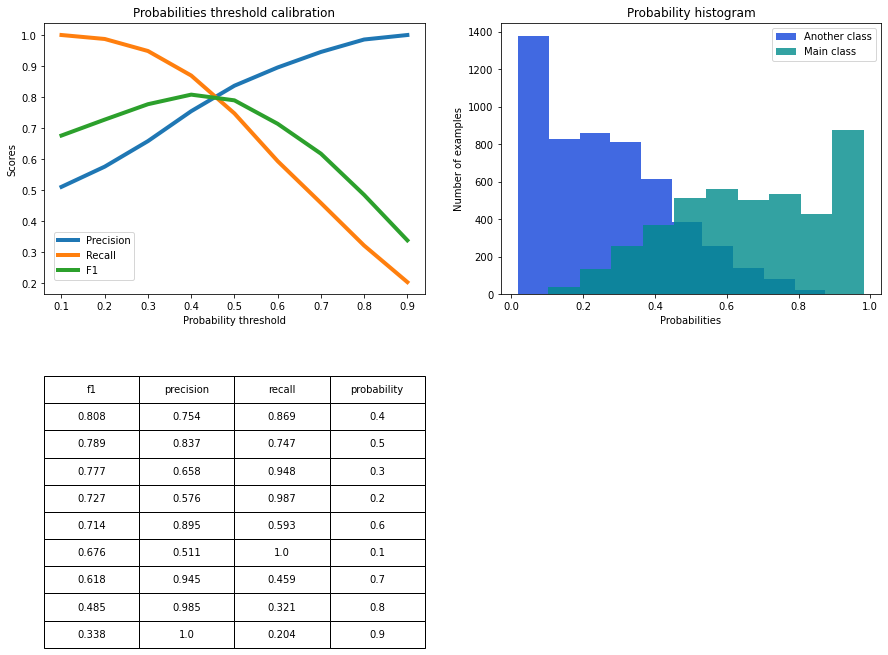

In [38]:
learning_processor.evaluate_full(stack_model)

In [39]:
learning_processor.predict_test(stack_model)
learning_processor.save_test('classification_stack_model')

## Predicting

## Evaluating